# Checkpoint 3

**Due: Friday, 4 December, 2020 at 5:00pm GMT**

### Read This First
1. Use the constants provided in the cell below. Do not use your own constants.

2. Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc. **Additional cells need to be in the proper order such that your code runs correctly the first time through.**

3. **IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.


# NMR spectrum of water

This problem concerns obtaining the nuclear magnetic resonance (NMR) spectrum of water from a raw NMR signal.

Given: a file containing the free-induction decay signal $y(t)$ (electromagnetic radiation emitted by protons in water), following an RF $\pi$-pulse of f=60MHz. The recorded signal is frequency-subtracted, i.e., the radio-frequency output signal has been mixed with the carrier frequency f=60MHz to shift the signal to lower frequencies in the range of hundreds of Hz.

The signal has three main components: the actual NMR signal from protons in water molecules, white noise, and a 50 Hz "mains hum" (electrical signal picked up by the sensitive NMR detector, coming from the mains AC; the signal also contains higher harmonics).

### Hints on how to solve this checkpoint:
- The code must work (and will be tested on) for other data files, in which the frequency of the water peak may differ by 10%. Any 'fine-tuning' of your algorithms so that they only work for the given data file is therefore discouraged.
- Write the code in a modular way so that you can re-use functions from previous tasks. This will save you a lot of time.
- Do not make the code more complex that it needs to be. Classes, complex data structures etc. are not required for this checkpoint.
- Use NumPy/SciPy functions rather than your own implementation whenever possible.
- As in CP1 and CP2, apart from numerical accuracy, efficiency and coding style will also be marked. Try to make your code readable.
- Comment on the results obtained. This may help to get a better mark if there is a problem with the code.

**There are 6 tasks in this CP worth 100 points, plus a bonus task 7 worth 15 points. The total mark will be the sum of all marks, or 100 points, whichever is lower.**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import time
from scipy import integrate, optimize
from matplotlib.ticker import FormatStrFormatter

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Task 1 (15p)

Load the data from the file "signals/water_16_samples.csv" and make a plot of the recorded signal versus time for t=[0,0.05), for the first of the 16 samples. Label the axes.

Each row of the data file (except the first which contains table headings) has the following format:

time, s1, s2, s3, ...

where "time" is in seconds, and s1,s2,s3,... represent the NMR signal (arbitrary units) from independent realisations of the experiment. Differences between the samples should be only due to noise; it is the same experiment repeated 16  times.

In [3]:
alternative = False  # Boolean variable to determine which dataset to be used.

if(alternative):
    data = pd.read_csv("signals/water_16_samples_v2.csv")  # alternative dataset
else:
    data = pd.read_csv("signals/water_16_samples.csv")  # original dataset
    
print(data.shape)

(30000, 17)


In [4]:
def task1(data):
    
    """
    Plots the recorded NMR signal 's1' versus time for t=[0,0.05).
    
    Parameters
    ----------
    data : array
        The original data of all 16 recorded signals, including time.
        
    Returns
    -------
    t : array
        The time values in seconds.
    s1 : array
        The recorded signal of the first of the 16 samples.
    """
    
    t = data['t']
    s1 = data['s1']
    plt.plot(t, s1)
    plt.xlim(-0.001,0.05)   # Left margin is slightly lower than 0 for a clearer visualisation
    plt.xlabel('t in seconds')
    plt.ylabel('y(t)')
    plt.title("NMR signal 's1' versus time for t=[0,0.05)")
    plt.show()
    
    return t, s1

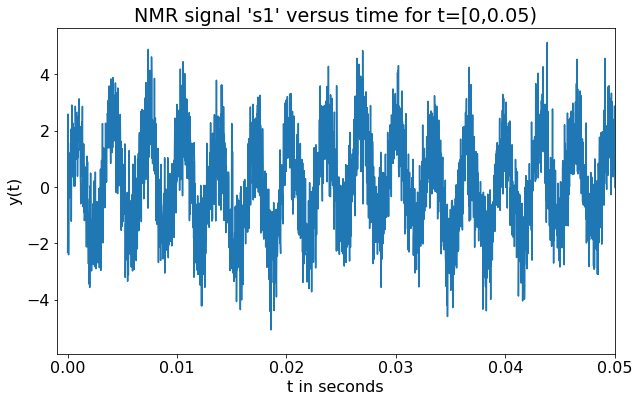

In [5]:
t, s1 = task1(data)

# Task 2 (15p)

Calculate the amplitude spectrum of the NMR signal, and plot it as a function of frequency f [Hertz], for f=0 to 500 Hz. Assume the length of the time series is tmax=0.5s.

**Note: in workshop, you have been plotting wavenumber ($k = \frac{2\pi}{\lambda}$), whereas frequency is $f = \frac{1}{\lambda}$.**

In [6]:
def fft(sample):
    
    """
    Performs Fast Fourier Transform on the recorded signal of the given sample to produce its amplitude spectrum.
    
    Parameters
    ----------
    sample : array
        The recorded NMR signal of the sample.
        
    Returns
    -------
    freq : array
        Frequency values in Hertz. 
    hh : array
        The amplitude spectrum of the NMR signal.
    """
    
    hh = np.fft.rfft(sample)
    nn = hh.size
    tmax = 0.5
    freq = np.linspace(0, (nn-1)/tmax, nn)
    
    return freq, hh

def task2_plot(freq, hh):
    
    """
    Plots the amplitude spectrum as a function of frequency from f=0 to 500 Hz.
    
    Parameters
    ----------
    freq : array
        Frequency values in Hertz.
    hh : array
        The amplitude spectrum of the NMR signal.
    """
    
    plt.plot(freq, 2*abs(hh)/t.size )  # Recover original amplitude by rescaling 
    plt.xlabel('Frequency in Hz')
    plt.xlim(0,500)
    plt.ylabel('$\\bar{y}_{f}$') 
    plt.title("Amplitude spectrum of the NMR signal 's1'\n as a function of frequency")
    plt.show()

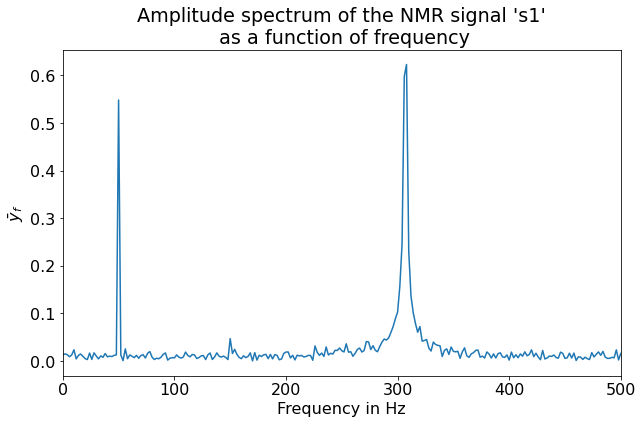

In [7]:
freq, hh = fft(s1)
task2_plot(freq, hh)

# Task 3 (15p)

Filter out the noise by passing the signal through a bandpass filter centered at the water peak with a width $\pm$30 Hz. Plot the filtered signal y(t) for t=[0,0.5).

In [8]:
def filter_signal(freq, hh, width):
    
    """
    Finds the peak frequency and filters out the signal (noise) outside the centered peak ± the width value.
    
    Parameters
    ----------
    freq : array
        Frequency values in Hertz.
    hh : array
        The original amplitude spectrum of the NMR signal.
    width : float
        Determines the width of the isolated peak.
        
    Returns
    -------
    freq : array
        Frequency values in Hertz.
    hh : array
        The filtered amplitude spectrum of the NMR signal.
    peak_f : float
        The value of the frequency of the water peak in Hz.
    """
    
    imaxf = np.abs(hh).argmax()  # index of the peak of the amplitude spectrum
    hh[np.abs(freq - freq[imaxf]) > width] = 0
    peak_f = freq[imaxf]
    
    return freq, hh, peak_f

def task3_plot(freq, filtered_hh):
    
    """
    Performs inverse Fourier Transform on the filtered amplitude spectrum to obtain and plot the 
    re-created filtered signal as a function of time, in addition to the isolated water peak.
    
    Parameters
    ----------
    freq : array
        Frequency values in Hertz.
    filtered_hh : array
        The filtered amplitude spectrum of the NMR signal.
        
    Returns
    -------
    filtered_signal : array
        The re-created filtered signal.
    """
    
    plt.plot(freq, abs(2*filtered_hh)/t.size)  # Recover original amplitude by rescaling 
    plt.xlabel('Frequency in Hz')
    plt.xlim(0,500)
    plt.ylabel('$\\bar{y}_{f}$') 
    plt.title("Isolated water peak ± 30 Hz")
    plt.show()

    filtered_signal = np.fft.irfft(filtered_hh)  # Inverse Fourier Transform
    plt.plot(t, filtered_signal)
    plt.xlabel('t in seconds')
    plt.ylabel('y(t)')
    plt.title("Re-created filtered signal as a function of time")
    plt.show()
    
    return filtered_signal

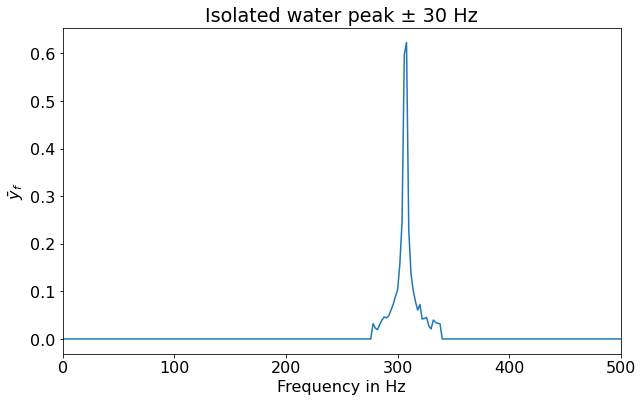

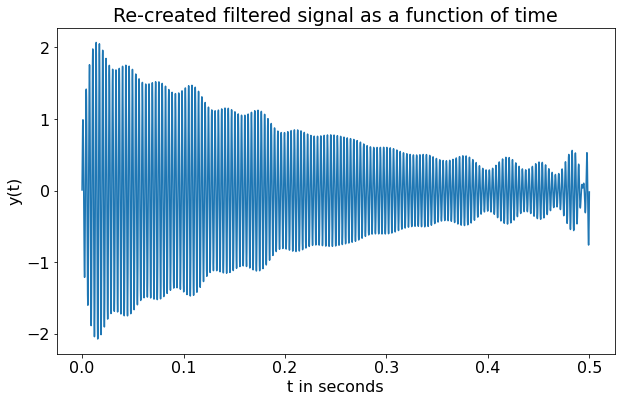

In [9]:
freq, filtered_hh, peak_f = filter_signal(freq, hh, 30)
filtered_signal = task3_plot(freq, filtered_hh)

# Task 4 (20p)

Use non-linear curve fitting to fit the function:

$
\Large
\begin{align}
y_{\rm theor}(t) = A \sin(2\pi f_0 t) e^{-t/t_0}
\end{align}
$

to the filtered signal for t=[0,tmax), with unknown parameters $A, f_0, t_0$. Find and print out the best-fit frequency $f_0$. The frequency should be accurate to within 0.01 Hz of the correct answer.

In [10]:
def y_theor(t, A, f0, t0):
    
    """
    Exponentially decaying sinusoidal function.
    
    Parameters
    ----------
    t : array
        The time values in seconds.
    A : float
        Amplitude of the exponentially decaying sinusoidal function.
    f0 : float
        Frequency of the exponentially decaying sinusoidal function.
    t0 : float
        Time constant of the exponentially decaying sinusoidal function.
        
    Returns
    -------
    y : array
        y(t) values.
    """
    
    y = A * np.sin(2*np.pi*f0*t) * np.exp(-t/t0)
    return y

def signal_fit(t, filtered_signal, peak_f):
    
    """
    Fits the exponentially decaying sinusoidal function to the re-created filtered signal using initial guesses p0.
    Also prints out the best-fit parameters with their corresponding standard deviations.
    
    Parameters
    ----------
    t : array
        The time values in seconds.
    filtered_signal : array
        The re-created filtered signal.
    peak_f : float
        The value of the frequency of the water peak in Hz.
        
    Returns
    -------
    signal_fit : array
        Best-fit to the filtered signal.
    """
    
    # A0 initial guess
    A0 = np.max(filtered_signal) 
    # Use A0 and peak_f in initial guesses. Also, t0 initial guess is around 0.2, since that's
    # where the filtered signal has an amplitude of around A0 / e
    pars, cov = optimize.curve_fit(y_theor, t, filtered_signal, p0=[A0, peak_f, 0.2])
    
    stdevs = np.sqrt(cov.diagonal())   # Standard deviations of best-fit parameters
    names = ['A', 'f0', 't0']    # Names of best-fit parameters
    
    print(f"Best-fit Parameters:")
    for i in range(len(pars)):
        print(f"{names[i]} = {pars[i]:.5f} with standard deviation = {stdevs[i]:.5f}")

    signal_fit = y_theor(t, *pars)
    return signal_fit

def task4_plot(t, filtered_signal, signal_fit):
    
    """
    Plots the re-created filtered signal and its best fit curve as a function of time.
    
    Parameters
    ----------
    t : array
        The time values in seconds.
    filtered_signal : array
        The re-created filtered signal.
    signal_fit : array
        Best-fit to the filtered signal.
    """
    
    plt.plot(t, filtered_signal, label='Filtered Signal')
    plt.plot(t, signal_fit, label='Signal best-fit', alpha=0.7)
    plt.xlabel('t in seconds')
    plt.ylabel('y(t)')
    plt.title("Filtered signal and its best-fit curve as a function of time.")
    plt.legend()
    plt.show()

Best-fit Parameters:
A = 1.96872 with standard deviation = 0.00248
f0 = 307.02710 with standard deviation = 0.00086
t0 = 0.25170 with standard deviation = 0.00051


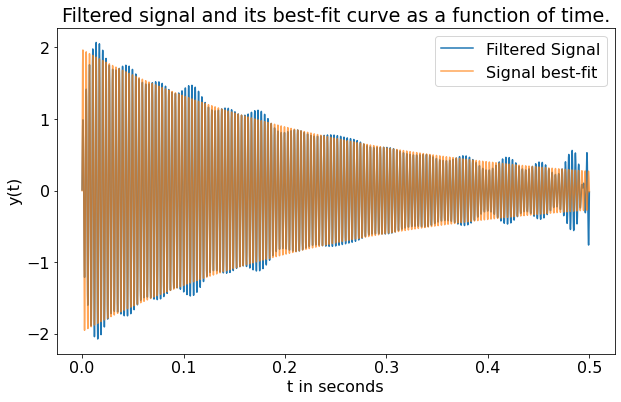

In [11]:
signal_fit = signal_fit(t, filtered_signal, peak_f)
task4_plot(t, filtered_signal, signal_fit)

In [12]:
print ("There will be tests here. Great job so far!")

There will be tests here. Great job so far!


# Task 5 (20p)

Determine $f_0$ in a different way: find the position of the water peak in the amplitude spectrum by fitting the curve

$
\large
\begin{align}
\tilde{y}_{\rm theor}(f) = C + \frac{A}{\sqrt{\lambda^4 + (f^2 - f_0^2)^2 + 2 \lambda^2(f^2 + f_0^2))}}
\end{align}
$

This curve comes from Fourier-transforming the exponentially damped sine function from the previous task, plus a constant C to account for background noise. $\lambda$ denotes the damping rate (inversely proportional to $t_0$ from task 4).

As before, use only the first of the 16 samples for this task. The frequency should be accurate to within 0.01 Hz of the correct answer.

Best-fit Parameters:
A = 6260685.72625 with standard deviation = 15862.11435
f0 = 307.02360 with standard deviation = 0.00153
λ = 0.48575 with standard deviation = 0.00729
C = -1.84848 with standard deviation = 0.13254


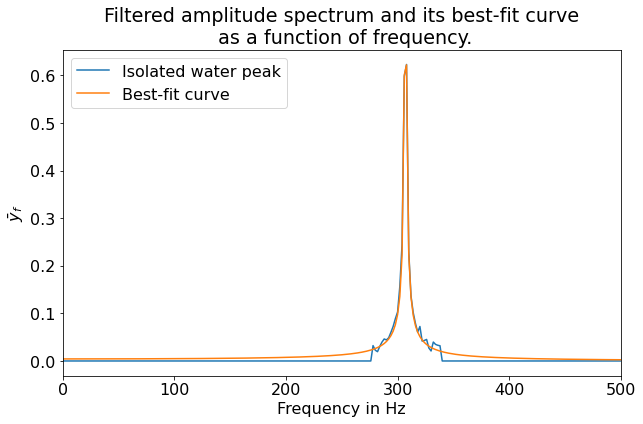

In [13]:
def ybar_theor(f, A, f0, lamda, C):
    
    """
    Fourier transform of the exponentially decaying sinusoidal function plus background noise.
    
    Parameters
    ----------
    f : array
        Frequency values in Hertz.
    A : float
        Amplitude of the function.
    f0 : float
        Natural frequency of the function.
    lamda : float
        Decay constant of the function.
    C : float
        Constant for background noise.
        
    Returns
    -------
    y : array
        y(t) values.
    """
    y = C + (A / np.sqrt(lamda**4 + (f**2 - f0**2)**2 + (2*lamda**2)*(f**2 + f0**2)))
    return y

def ampl_fit(freq, filtered_hh, peak_f):
    
    """
    Fits the function above to the filtered amplitude spectrum using initial guesses p0.

    Parameters
    ----------
    freq : array
        Frequency values in Hertz.
    filtered_hh : array
        The filtered amplitude spectrum of the NMR signal.
    peak_f : float
        The value of the frequency of the water peak in Hz.
        
    Returns
    -------
    pars : array
        Values of best-fit parameters.
    stdevs : array
        Standard deviations of best-fit parameters.
    names : list
        Names of best-fit parameters.
    """
    
    # A0 initial guess
    A0 = np.max(abs(filtered_hh))  
    # Use A0 and peak_f in initial guesses. Also, λ initial guess is 5, since that's the inverse of
    # the t0 guess from task4, and initial guess for C is 0.
    pars, cov = optimize.curve_fit(ybar_theor, freq, abs(filtered_hh), p0=[A0, peak_f, 5, 0])
    
    stdevs = np.sqrt(cov.diagonal())
    names = ['A', 'f0', 'λ', 'C']

    return pars, stdevs, names

def task5_plot(freq, filtered_hh):
    
    """
    Calls the 'ampl_fit' function and prints out the best-fit parameters with their 
    corresponding standard deviations.
    Also plots the isolated water peak and its best-fit curve as a function of frequency.

    Parameters
    ----------
    freq : array
        Frequency values in Hertz.
    filtered_hh : array
        The filtered amplitude spectrum of the NMR signal.
    """
    
    best_fit_pars, stdevs, names = ampl_fit(freq, filtered_hh, peak_f)
    print(f"Best-fit Parameters:")
    for i in range(len(best_fit_pars)):
        print(f"{names[i]} = {best_fit_pars[i]:.5f} with standard deviation = {stdevs[i]:.5f}")
    
    plt.plot(freq, abs(2*filtered_hh/t.size), label='Isolated water peak')
    best_fit = ybar_theor(freq, *best_fit_pars)
    plt.plot(freq, abs(2*best_fit/t.size), label='Best-fit curve')
    plt.xlabel('Frequency in Hz')
    plt.xlim(0,500)
    plt.ylabel('$\\bar{y}_{f}$') 
    plt.legend()
    plt.title("Filtered amplitude spectrum and its best-fit curve\n as a function of frequency.")
    plt.show()

task5_plot(freq, filtered_hh)

In [14]:
print ("Tests here. Keep it up!")

Tests here. Keep it up!


# Task 6 (15p)

Determine the frequency $f_0$ for all 16 data sets using the method from Task 5. Calculate mean $f_0$ and its standard error. The frequency should be accurate to within 0.01 Hz of the correct answer and the standard error should be within 1%.

In [15]:
def task6():
    
    """
    This function basically re-uses lots of functions defined throughout this checkpoint. For each of the 16 samples, the 
    NMR signal is Fourier Transformed, and then its amplitude spectrum is filtered and fitted to the equation from task 5.
    The best-fit frequency f0 is printed out with its standard deviation, and then stored in a list f0s. Finally,
    the mean f0 from all 16 samples is calculated and printed out, along with its standard error, which is calculated 
    using SE = σ / sqrt(n), where n is the number of data sets (16) and σ is the standard deviation between the 16 values.
    """        
    
    samples = data.drop(columns='t').columns
    f0s = []
    for s in samples:
        sample = data[s]
        freq, hh = fft(sample)
        freq, filtered_hh, peak_f = filter_signal(freq, hh, 30)
        best_fit_pars, stdevs, names = ampl_fit(freq, filtered_hh, peak_f)
        f0 = best_fit_pars[1]
        print(f"For sample {s}, the best-fit f0 is {f0:.5f} with std dev = {stdevs[1]:.5f}.")
        f0s.append(f0)
    
    standerr = np.std(f0s) / np.sqrt(samples.size)

    print(f"\nThe mean f0 is: {np.mean(f0s):.5f} and standard error : {standerr:.5f}") 

task6()

For sample s1, the best-fit f0 is 307.02360 with std dev = 0.00153.
For sample s2, the best-fit f0 is 307.02372 with std dev = 0.00146.
For sample s3, the best-fit f0 is 307.03478 with std dev = 0.00151.
For sample s4, the best-fit f0 is 307.01488 with std dev = 0.00138.
For sample s5, the best-fit f0 is 307.05050 with std dev = 0.00167.
For sample s6, the best-fit f0 is 307.01056 with std dev = 0.00156.
For sample s7, the best-fit f0 is 307.01103 with std dev = 0.00147.
For sample s8, the best-fit f0 is 307.02209 with std dev = 0.00165.
For sample s9, the best-fit f0 is 307.01240 with std dev = 0.00153.
For sample s10, the best-fit f0 is 307.01908 with std dev = 0.00150.
For sample s11, the best-fit f0 is 307.02360 with std dev = 0.00153.
For sample s12, the best-fit f0 is 307.03327 with std dev = 0.00153.
For sample s13, the best-fit f0 is 307.02358 with std dev = 0.00156.
For sample s14, the best-fit f0 is 307.00620 with std dev = 0.00145.
For sample s15, the best-fit f0 is 307.0180

In [16]:
print ("Tests here. Almost there!")

Tests here. Almost there!


# Bonus: Task 7 (15p)

Find the 95% equally-tailed credible interval of $f_0$ from task 5 using Bayesian inference.

Use only the first of the 16 samples for this task. Assume the spectrum can be modelled by the curve from task 5, with $C=0$ and random noise superimposed on the curve. The noise should be generated as independent, identically distributed random numbers $\{\chi_k\}$ drawn from the Chi distribution with two degrees of freedom and unknown amplitude $\sigma$, so that the amplitude spectrum is

$
\large
\begin{align}
\tilde{y}_k = \frac{A}{\sqrt{\lambda^4 + (f_k^2 - f_0^2)^2 + 2\lambda^2(f_k^2 + f_0^2))}} + \sigma \chi_k
\end{align}
$

where $f_k = k/t_{max}$. The rationale for using the Chi distribution comes from Fourier-transforming Gaussian noise and taking its modulus (to plot the amplitude spectrum).

Does the average value of $f_0$ obtained in task 6 lie in the credible interval? The bounds of the interval should be accurate to within 0.01 Hz of the correct answer.

In [17]:
def ybar_k(f, A, f0, lamda, sigma):
    """
    Fourier transform of the exponentially decaying sinusoidal function plus random noise drawn from 
    the Chi distribution with two degrees of freedom, also known as Rayleigh Distribution.
    
    Parameters
    ----------
    f : array
        Frequency values in Hertz.
    A : float
        Amplitude of the function.
    f0 : float
        Natural frequency of the function.
    lamda : float
        Decay constant of the function.
    sigma : float
        Amplitude for background noise.
        
    Returns
    -------
    y : array
        y(t) values.
    """
    
    noise = sigma * np.random.rayleigh(size = f.size) 
    y = noise + (A / np.sqrt(lamda**4 + (f**2 - f0**2)**2 + (2*lamda**2)*(f**2 + f0**2)))
    return y

def distance(y1, y2):
    """
    Computes the sum of squared differences between two curves.
    
    Parameters
    ----------
    y1 : array
        Curve 1.
    y2 : array
        Curve 2.
        
    Returns
    -------
    dist : array
        Sum of squared differences between two curves.
    """    
    dist = ((y1 - y2)**2).sum()
    return dist

def ABC(nreps, epsilon, ranges, model_func, dist_func):
    """
    Performs Approximate Bayesian computation.
    
    Parameters
    ----------
    nreps : int
        The number of trials.
    epsilon : float
        The maximum distance for a model to be accepted.
    ranges : list of lists of floats
        A list of min, max values for each model parameter.
    model_func : function
        Model function.
    dist_func : function
        Distance function.
        
    Returns
    -------
    selected : array
        Parameters of the accepted models.
    """
    
    selected = []
    
    for i in range(nreps):
        
        # Create random parameters for each of the provided ranges.
        pars = [np.random.uniform(*r) for r in ranges]

        # Compute the distance between the model and the data.
        normalisation = 2 / t.size  # rescaling 
        dist = dist_func(abs(filtered_hh)*normalisation, model_func(freq, *pars)*normalisation)

        # Keep the parameters if the model is accepted.
        if dist < epsilon:
            selected.append(pars)

    print(f"Epsilon: {epsilon}, Accepted Sets: {len(selected)} ({100*len(selected)/nreps}%).")
    return np.array(selected)

def histogram(data, name):
    """
    Computes and plots the histogram of the given data, in addition to printing out the mean and standard deviation
    of the data. Then, it calculates the 95% equally-tailed credible interval and prints it out.
    
    Parameters
    ----------
    data : array
        Data values.
    name : Str
        Name of the variable.
    """
    plt.rcParams['font.size'] = 14
    fig, ax = plt.subplots()
    bins = 10
    plt.hist(data, bins, density = False, rwidth=0.98)
    plt.xlabel(f'${name}$')
    plt.ylabel('N')
    plt.xticks(np.linspace(np.min(data), np.max(data), bins+1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.title("Histogram showing the distribution of f0 values\n from the accepted sets of the ABC method")
    plt.show()

    print(f"Mean = {data.mean()}.")
    print(f"Standard deviation = {data.std()}.")

    # determine 95% credible interval
    # first sort the data
    data = np.sort(data)
    # 2.5% = 1 / 40, so take the parameters at indices N/40 and N-N/40.
    print("\n95% equally-tailed credible interval:")
    print(f"({name}-, {name}+) = {data[len(data)//40]}, {data[-len(data)//40]}.")

Epsilon: 0.07, Accepted Sets: 952 (0.952%).


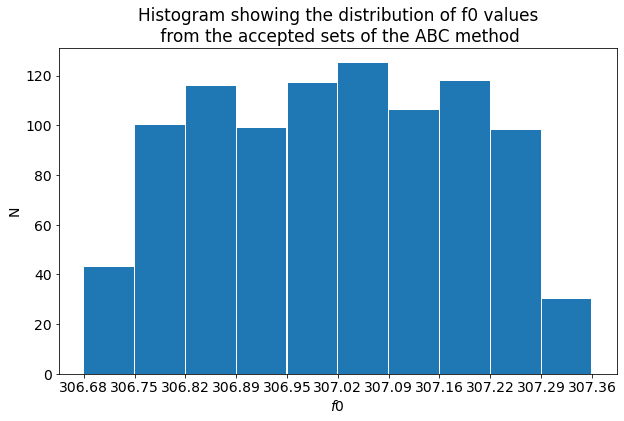

Mean = 307.01803946561154.
Standard deviation = 0.16764555181368965.

95% equally-tailed credible interval:
(f0-, f0+) = 306.7327435006052, 307.3043907809276.

The average value of f0 obtained in task 6 lies within the credible interval.

Time to solution: 130.2952480316162 seconds.


In [18]:
def task7():
    
    """
    Task7() uses the functions defined above to run ABC with all epsilon values in eps_vals, for n_trials. 
    To determine which ranges to give the ABC method, the best-fit parameters from task 5 are used, but ± 10%.
    During my experiments, the eps_vals array contained a range of epsilon values. I run the ABC method for all
    of them, and then plotted the number of accepted sets and standard deviation of f0 as a function of epsilon.
    I decided to keep an optimal epsilon value of 0.07, since about 1% of total sets is accepted for the original
    dataset, and about 2% for the alternative one.
    
    """
    
    eps_vals = [0.07]   # Can be extended to contain multiple values (linspace) for experimenting.
    n_trials = 100000   # If larger, the ABC method takes lots of time, but may give better results.

    acceptance = []
    stddev = []

    best_fit_pars, stdevs, names = ampl_fit(freq, filtered_hh, peak_f)  # Filtered amplitude spectrum of 's1' sample
    A0 = best_fit_pars[0]
    f0 = best_fit_pars[1]
    lamda = best_fit_pars[2]

    ranges = [[A0*0.9, A0*1.1],
              [f0*0.9, f0*1.1],
              [lamda*0.9, lamda*1.1],
              [-10, 10]]

    for my_eps in eps_vals:
       
        sel = ABC(n_trials, my_eps, ranges, ybar_k, distance)
        acceptance.append(len(sel))
        stddev.append(sel[:, 1].std())
        histogram(sel[:,1], "f0")
        
        print("\nThe average value of f0 obtained in task 6 lies within the credible interval.\n")

t1 = time.time()
task7()
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

In [19]:
print ("Tests. Nice work!")

Tests. Nice work!
